# Figures for the AGU presentation

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-talk')

In [3]:
def extract_lines(name):
    """Get data <name>."""
    inp = xr.load_dataset(name, engine='h5netcdf')
    out = np.stack([
        inp.line_1[::2]+1j*inp.line_1[1::2],
        inp.line_2[::2]+1j*inp.line_2[1::2],
        inp.line_3[::2]+1j*inp.line_3[1::2],
    ]).T
    return out

def get_pos_neg(resp, off, min_off):
    """Separate positive and negative values, enforce min_off."""
    resp_pos = np.array([x if x > 0 else np.nan for x in resp])
    resp_neg = np.array([-x if x < 0 else np.nan for x in resp])

    resp_pos[off < min_offset] = np.nan
    resp_neg[off < min_offset] = np.nan

    return resp_pos, resp_neg

In [4]:
ds = xr.load_dataset('../../model-block/block_model_and_survey.nc', engine='h5netcdf')
rec_x = ds.x[::2].data
rec_y = ds.attrs['rec_y']

In [5]:
data = {
    'empymod': 'empymod',
    'emg3d': 'emg3d',
    'custEM': 'custEM_p2',
    'PETGEM': 'petgem',
    'SimPEG': 'simpeg',
}

# Load all data
for key, value in data.items():
    data[key] = extract_lines(f"../../model-block/results/layered_{value}.nc")
    
# Compute relative error (%)
error = {}
aerror = {}
for name in ['emg3d', 'custEM', 'PETGEM', 'SimPEG']:
    re_error = 100*abs((data['empymod'].real - data[name].real)/data['empymod'].real)
    im_error = 100*abs((data['empymod'].imag - data[name].imag)/data['empymod'].imag)
    error[name] = re_error + 1j*im_error
    aerror[name] = 100*abs((np.abs(data['empymod']) - np.abs(data[name]))/np.abs(data['empymod']))

## Comparison Plots

In [6]:
# We plot data at offsets < min_offset
min_offset = 500

# Markers for scatter plots
marker = ['*', 'v', '^', 'o']
ms = [7, 6, 5, 4]

# Properties we loop over or use in loops
reim = [np.real, np.imag, np.abs]

<ipython-input-7-fe948f5fee21>:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


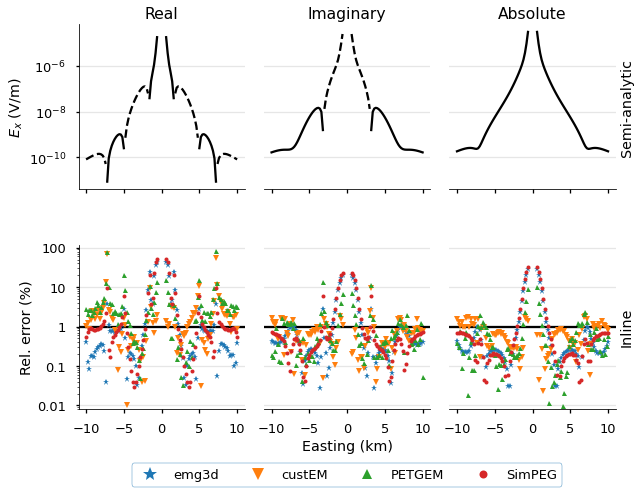

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(9, 6.5), sharex=True, sharey='row')
((ax1, ax2, ax3), (ax4, ax5, ax6)) = axs

# # (A) Plot semi-analytical responses # #

# Plot over real, imaginary
for i, ax in enumerate(axs[0, :]):

    # Title
    ax.set_title(['Real', 'Imaginary', 'Absolute'][i])

    # Get offset
    off = np.sqrt(rec_x**2 + rec_y[1]**2)

    # Get positive and negative values
    resp_pos, resp_neg = get_pos_neg(
        reim[i](data['empymod'][:, 1]), off, min_offset)

    # Plot them
    ax.plot(rec_x/1e3, resp_pos, '-', c='k')
    ax.plot(rec_x/1e3, resp_neg, '--', c='k')

    # Axis labeling, scaling, etc
    ax.set_yscale('log')
    ax.set_xticks([-10, -5, 0, 5, 10])
    ax.grid(axis='y', c='0.9')
    if i == 2:
        ax.set_ylim(ax1.get_ylim())
        ax.yaxis.set_label_position("right")
        ax.set_ylabel('Semi-analytic')
    elif i == 0:
        ax.set_ylabel("$E_x$ (V/m)")


# # (B) Plot relative error # #

# Plot over ({Re;Im;Abs}-{inline;broadside})
for i, ax in enumerate(axs[1:, :].ravel()):

    # Loop over codes
    for ii, name in enumerate(error.keys()):

        # Set errors at offsets < min_offset to NaN
        error[name][off < min_offset, 1] = np.nan + 1j*np.nan

        # Plot
        if i % 3 == 2:
            perror = aerror[name][:, i//3+1]
        else:
            perror = reim[i%2](error[name][:, i//3+1])

        # Set errors at offsets < min_offset to NaN
        off = np.sqrt(rec_x**2 + rec_y[i // 3 + 1]**2)
        perror[off < min_offset] = np.nan

        ax.plot(rec_x/1e3, perror, f'C{ii}{marker[ii]}', ms=ms[ii], label=name)

    # Axis labeling, scaling, etc
    ax.set_yscale('log')
    ax.set_xticks([-10, -5, 0, 5, 10])
    ax.set_ylim([8e-3, 120])
    if i < 3:
        ax.grid(axis='y', c='0.9')
        ax.set_yticks([0.01, 0.1, 1, 10, 100])
        ax.set_yticklabels(['0.01', '0.1', '1', '10', '100'])
        if i in [2, 5]:
            ax.yaxis.set_label_position("right")
            ax.set_ylabel("Inline")
        elif i in [0, 3]:
            ax.set_ylabel('Rel. error (%)')
        ax.axhline(1, c='k', zorder=1.9)
    else:
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

# Switch off spines
for i, ax in enumerate(axs.ravel()):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if i%3 != 0:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position("none")
axs[1, 1].set_xlabel('Easting (km)')

fig.tight_layout(h_pad=5)

# Legends
l2 = ax5.legend(bbox_to_anchor=(0.5, -0.4), loc='center', framealpha=1,
                edgecolor='C0', ncol=4, markerscale=2)
axs[1, 1].set_zorder(10000)

fig.savefig(f'../figures/results-layered.pdf', bbox_inches='tight')   
fig.show()

In [8]:
import scooby
scooby.Report()

--------------------------------------------------------------------------------
  Date: Fri Nov 20 16:15:23 2020 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GB
       Environment : Jupyter

  Python 3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 01:22:49)
  [GCC 7.5.0]

             numpy : 1.19.1
             scipy : 1.5.2
           IPython : 7.18.1
        matplotlib : 3.3.1
            scooby : 0.5.6

  Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------